In [1]:
#hide
%reload_ext autoreload
%autoreload 2

import importlib
import alphaquant
importlib.reload(alphaquant)

<module 'alphaquant' from '/Users/constantin/workspace/alphaquant/alphaquant/__init__.py'>

In [2]:
import os

os.chdir("../../../test_data/system_tests/proteoforms/mann_labs_egfr")

In [3]:

EGFR_PROTEINS = "QuickGO-annotations-1689586252205-20230717.tsv"
SAMPLEMAP_FILE = "samplemap_egfr_100ng.tsv"
#RESULTS_DIR = "results"
RESULTS_DIR = "results_minrep5_fewclusterfilt"
PROTEIN_ID_MAPPING = "protein_mapping.tsv"
PHOSPHO_PREDLIB = "../phospho_predlib/human_uniprot_reviewed_phos_prob.tsv"


CONDPAIRS = [("untreated", "egf_treated")]
CONDPAIR = CONDPAIRS[0]


In [4]:
import pandas as pd

UNIPROT2ENTREZ = pd.read_csv(PROTEIN_ID_MAPPING, sep = "\t")
UNIPROT2ENTREZ = UNIPROT2ENTREZ.dropna(subset=['entrez'])
UNIPROT2ENTREZ["entrez"] = UNIPROT2ENTREZ["entrez"].astype(int)
UNIPROT2ENTREZ = dict(zip(UNIPROT2ENTREZ["uniprot"], UNIPROT2ENTREZ["entrez"]))

In [5]:
import pandas as pd

df_phospho_predlib = pd.read_csv(PHOSPHO_PREDLIB, sep='\t')
#drop all rows with ptm_prop < 0.5
predicted_phosphoprone_sequences = set(df_phospho_predlib[df_phospho_predlib['ptm_prob'] >= 0.5]["sequence"])
predicted_phosphoprone_sequences = {f"SEQ_{x}_" for x in predicted_phosphoprone_sequences}

In [6]:
import alphaquant.outlier_scoring as aqoutlier
import alphaquant.diffquant_utils as aqutils

condpairtree_proteome = aqutils.read_condpair_tree(cond1=CONDPAIR[0], cond2=CONDPAIR[1], results_folder=RESULTS_DIR)
#condpairtree_ptm = aqutils.read_condpair_tree(cond1=condpair[0], cond2=condpair[1], results_folder=results_dir_phospho)


In [11]:
import alphaquant.outlier_scoring as aqoutlier


#ptm_loader = aqoutlier.ModifiedPeptideLoader(condpairtree_ptm, specific_modification="_[")


#outlier_loader = aqoutlier.OutlierPeptideLoader(condpairtree_proteome)

#complemented_clusterloader = aqoutlier.ComplementedClusterLoader(outlier_peptide_loader=outlier_loader, modified_peptide_loader=ptm_loader)

In [15]:
import alphaquant.visualizations as aqplot
import alphaquant.outlier_scoring as aqoutlier



outlier_handler = aqoutlier.OutlierHandler(results_dir = RESULTS_DIR, cond1 = CONDPAIR[0], cond2 = CONDPAIR[1])
clusterdiffinfos_list = outlier_handler.get_diffclust_overview_list()
#clusterdiffinfos_list = [x for x in clusterdiffinfos_list if x.name in predicted_phosphoprone_sequences]


In [18]:
#clusterdiffinfos_list = [x for x in clusterdiffinfos_list if x.name in predicted_phosphoprone_sequences]
clusterdiffinfos_list_filtered = [x for x in clusterdiffinfos_list if len(x.peptide_names) < 3]
print(len(clusterdiffinfos_list_filtered))

38


In [9]:
import pandas as pd
def get_fcdiffs_df(list_of_clusterdiffinfos):
    df_dict = {}
    df_dict["protein_id"] = []
    df_dict["fcdiff"] = []
    df_dict["cluster_size"] = []

    for clusterdiffinfo in list_of_clusterdiffinfos:
        df_dict["protein_id"].append(clusterdiffinfo.protein_name)
        df_dict["fcdiff"].append(clusterdiffinfo.fcdiff)
        df_dict["cluster_size"].append(len(clusterdiffinfo.outlier_peptide_names))
    
    return pd.DataFrame(df_dict)


fcdiffs_df = get_fcdiffs_df(clusterdiffinfos_list)

fcdiffs_df = fcdiffs_df.sort_values(by=["fcdiff"])
display(fcdiffs_df)
#fcdiffs_df_maxdiff = fcdiffs_df.drop_duplicates(subset = ['protein_id'],keep='last')


,protein_id,fcdiff,cluster_size
126,P33991,0.000255,10
4477,P17676;P17676-2,0.000758,2
595,Q14157-5,0.001471,8
1838,P42704,0.001723,19
2821,Q01081,0.002189,2
...,...,...,...
952,Q14980,3.880325,1
3108,Q8WXH0;Q8WXH0-2,4.200341,1
2833,Q9UK76,4.344145,1
2053,P27797,4.437802,1


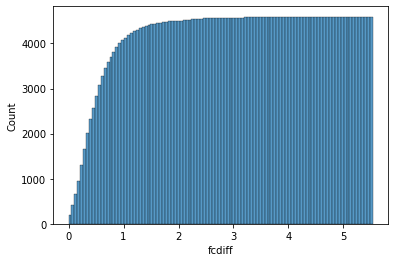

<AxesSubplot:xlabel='fcdiff', ylabel='cluster_size'>

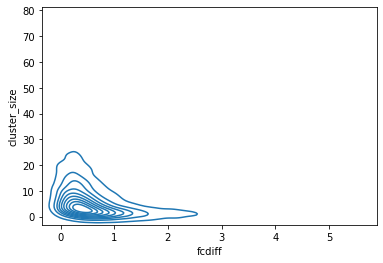

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(data=fcdiffs_df, x = "fcdiff",cumulative=True)
plt.show()

sns.kdeplot(data=fcdiffs_df, x = "fcdiff", y = "cluster_size")


In [72]:
import easygo.go_runner as go_runner

#get all protein ids with fcdiff larger than 0.75
fcdiff_threshold = 2
protein_ids_outlier = fcdiffs_df[(fcdiffs_df["fcdiff"]> fcdiff_threshold) & (fcdiffs_df["cluster_size"] < 2)]["protein_id"]
protein_ids_outlier = [id for protein in protein_ids_outlier for id in protein.split(";")]



In [73]:
all_protein_ids = [x.name for x in condpairtree_proteome.children]
all_protein_ids = [id for protein in all_protein_ids for id in protein.split(";")]


background_ids_entrez = [UNIPROT2ENTREZ.get(id) for id in all_protein_ids if id in UNIPROT2ENTREZ.keys()]

In [74]:
egfr_proteins_df = pd.read_csv(EGFR_PROTEINS, sep = "\t")
egfr_ids_entrez = [UNIPROT2ENTREZ.get(id) for id in egfr_proteins_df["GENE PRODUCT ID"] if id in UNIPROT2ENTREZ.keys()]
print(len(set(egfr_ids_entrez)))

18


In [75]:
#convert protein to entrez gene ids

target_ids_entrez = [UNIPROT2ENTREZ.get(id) for id in protein_ids_outlier if id in UNIPROT2ENTREZ.keys()]

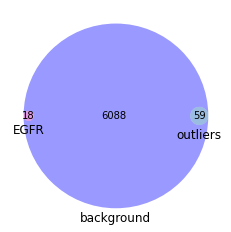

In [76]:
import matplotlib_venn as venn


res = venn.venn3([set(egfr_ids_entrez), set(target_ids_entrez), set(background_ids_entrez)], ["EGFR", "outliers", "background"])

In [77]:
import easygo.go_runner as go_runner

enrich_results = go_runner.run_go_enrichment_analysis(target_ids_entrez, background_ids_entrez, taxids=[9606], fdr_threshold=0.05)
display(enrich_results)
enrich_results.to_csv("/tmp/go_results.tsv", sep="\t")

  EXISTS: /Users/constantin/workspace/easygo/easygo/data/go-basic.obo
/Users/constantin/workspace/easygo/easygo/data/go-basic.obo: fmt(1.2) rel(2023-01-01) 46,739 Terms
  EXISTS: /Users/constantin/workspace/easygo/easygo/data/gene2go
HMS:0:00:04.019350 339,369 annotations, 20,700 genes, 18,988 GOs, 1 taxids READ: /Users/constantin/workspace/easygo/easygo/data/gene2go 

Load BP Ontology Enrichment Analysis ...
 94%  5,904 of  6,262 population items found in association

Load CC Ontology Enrichment Analysis ...
 97%  6,082 of  6,262 population items found in association

Load MF Ontology Enrichment Analysis ...
 97%  6,056 of  6,262 population items found in association

Runing BP Ontology Analysis: current study set of 61 IDs.
 90%     53 of     59 study items found in association
 97%     59 of     61 study items found in population(6262)
Calculating 8,412 uncorrected p-values using fisher_scipy_stats
   8,412 terms are associated with  5,813 of  6,262 population items
     529 terms a

INFO:biothings.client:querying 1-3...


   2,996 terms are associated with  5,961 of  6,262 population items
     157 terms are associated with     57 of     59 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)


INFO:biothings.client:done.
INFO:biothings.client:Finished.


,GO,name,namespace,p_uncorrected,p_fdr_bh,study_count,study_n,pop_count,pop_n,genes,gene_symbols
0,GO:0070849,response to epidermal growth factor,biological_process,7.947376e-07,0.006685,3,59,3,6262,"[5594, 5595, 7175]","[MAPK1, MAPK3, TPR]"


In [16]:
filtered_protnodes = [x for x in condpairtree_proteome.children if x.name.split(";")[0] in protein_ids_outlier]
print(len(filtered_protnodes))

73


In [17]:
import alphaquant.outlier_scoring as aqoutlier

dcfilt = aqoutlier.DiffClusterFilterer(clusterdiffinfos_list, aqoutlier.DiffClusterFilterConfig(fcdiff_quantile=0.001, quality_score_quantile=1, num_mainclust_peptides_quantile=1,num_outlierclust_peptides_quantile=1).filterconfigs)


filtlist = dcfilt.get_filtered_diffclust_list()
print(len(filtlist))

5


In [ ]:

quantification_info = aqplot.CondpairQuantificationInfo().init_by_loading_tables(cond1 = CONDPAIR[0], cond2 = CONDPAIR[1], results_dir = RESULTS_DIR, samplemap=SAMPLEMAP_FILE)
pepdf_getter = aqplot.PeptideIntensityDataframeGetter(quantification_info=quantification_info)


P35579


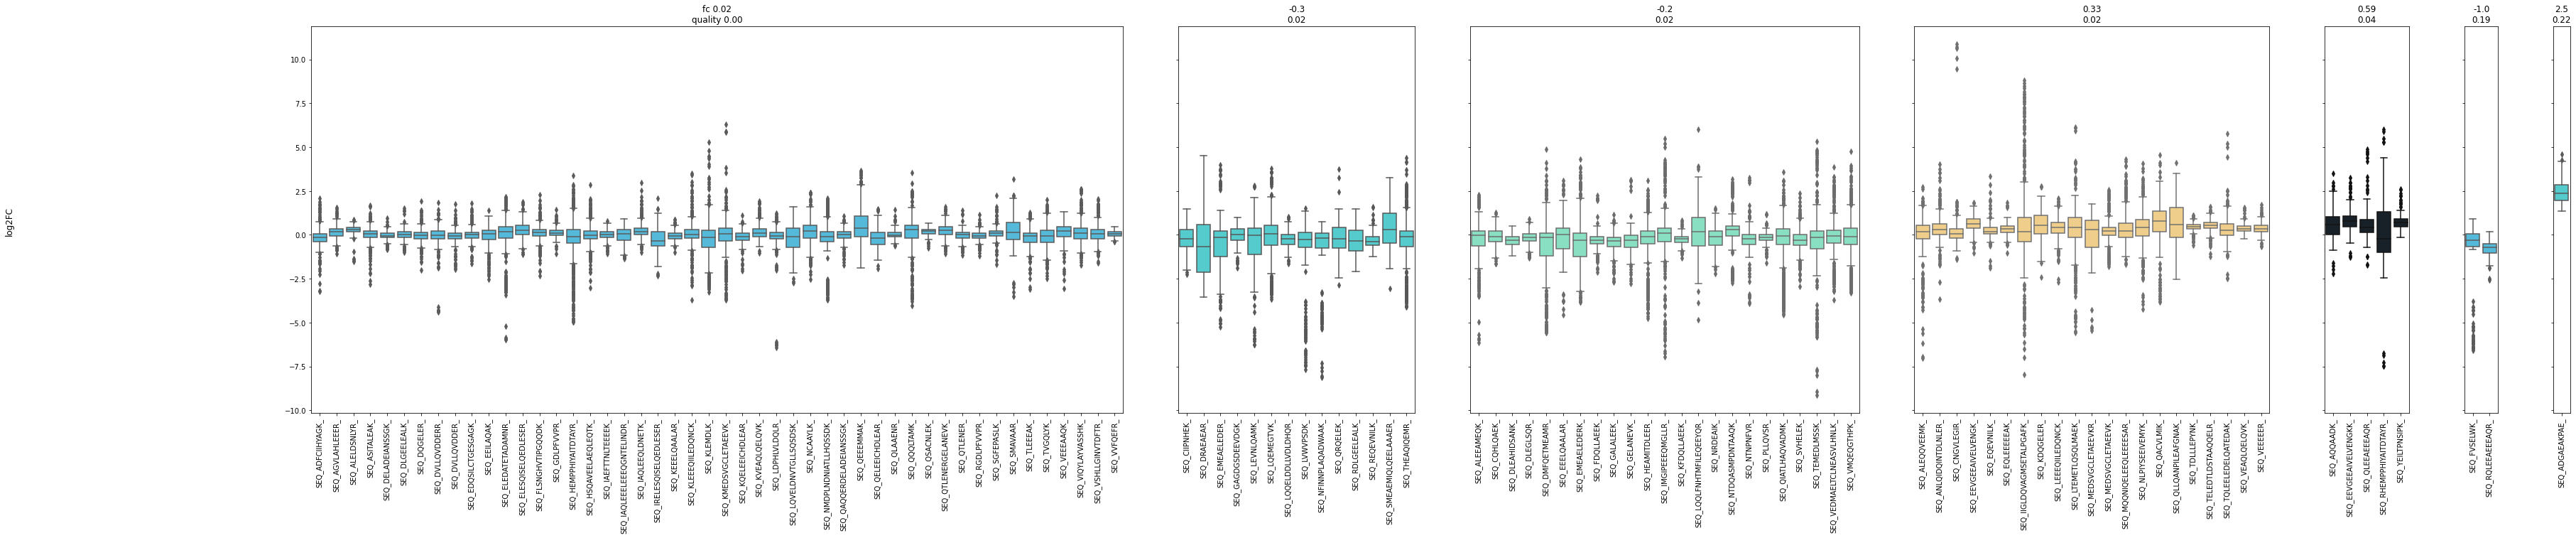

P33981;P33981-2


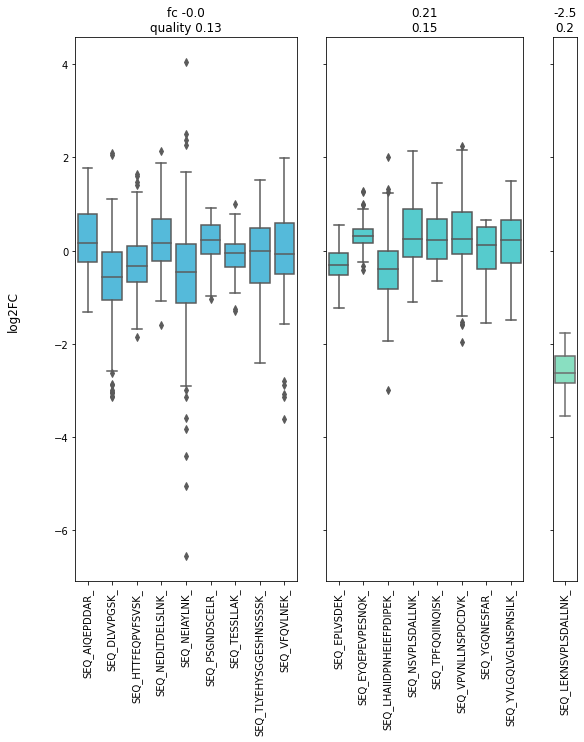

Q9NWT1


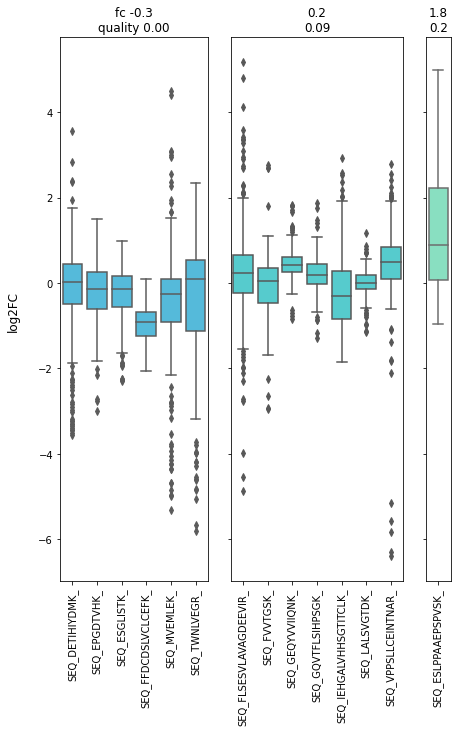

P17987


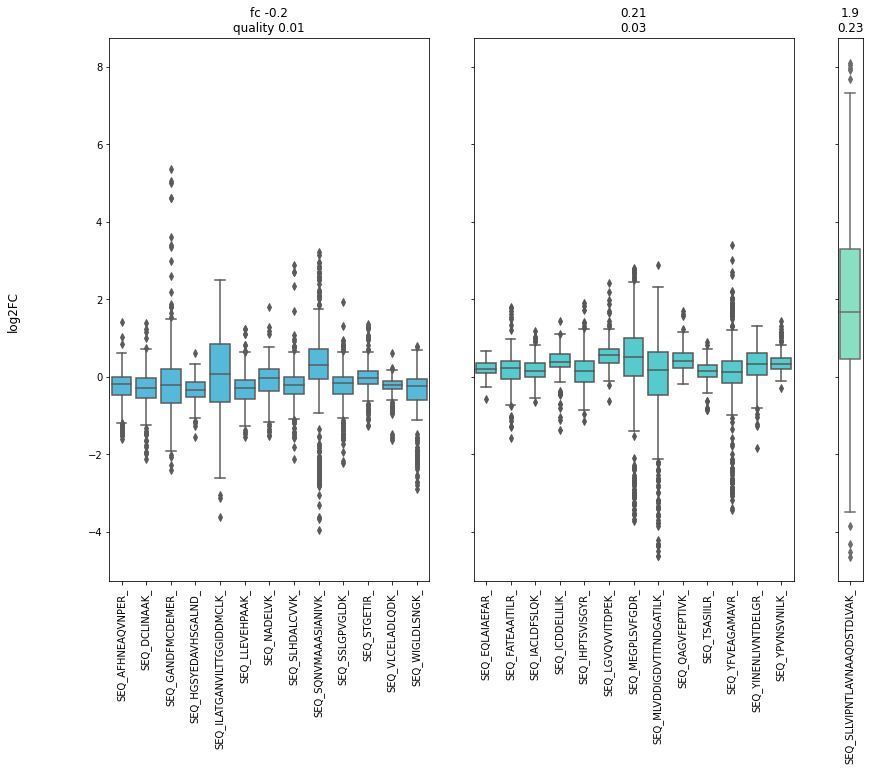

Q8WX93;Q8WX93-3


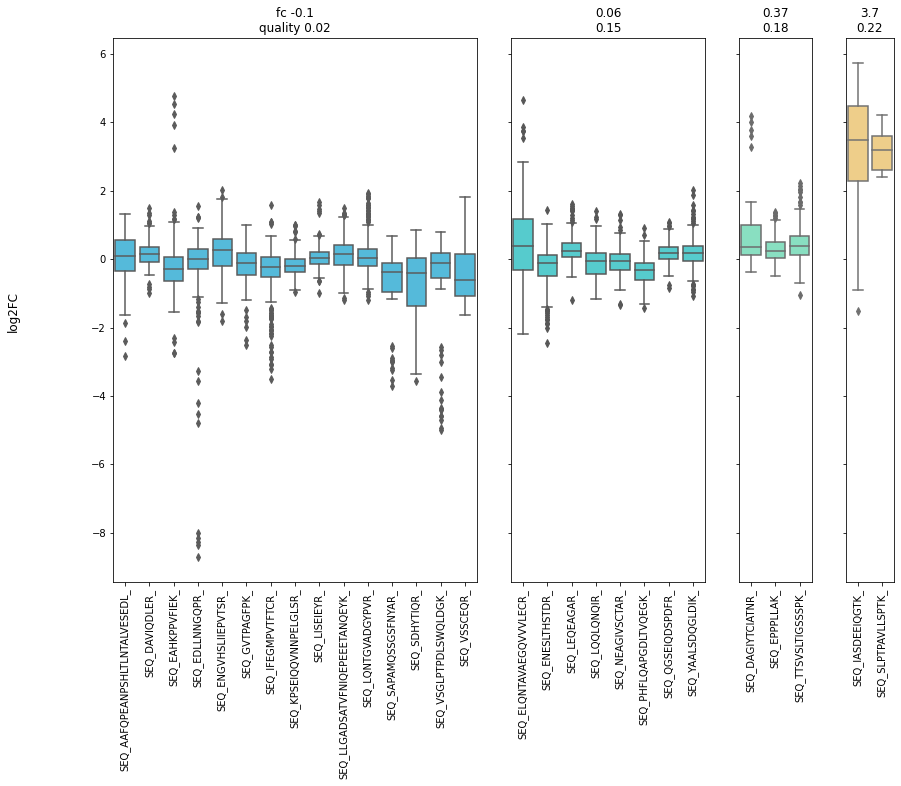

Q14157-5


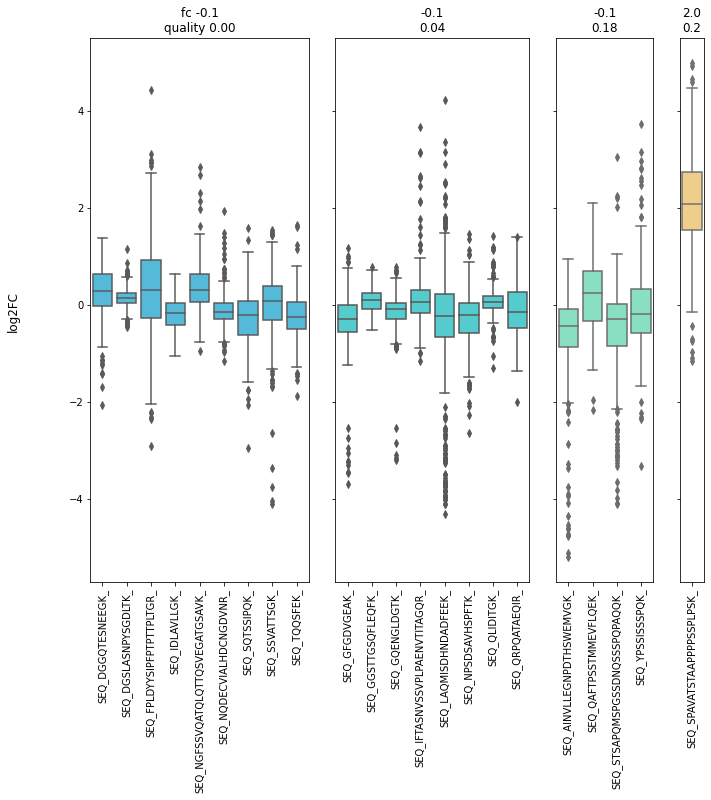

P12270


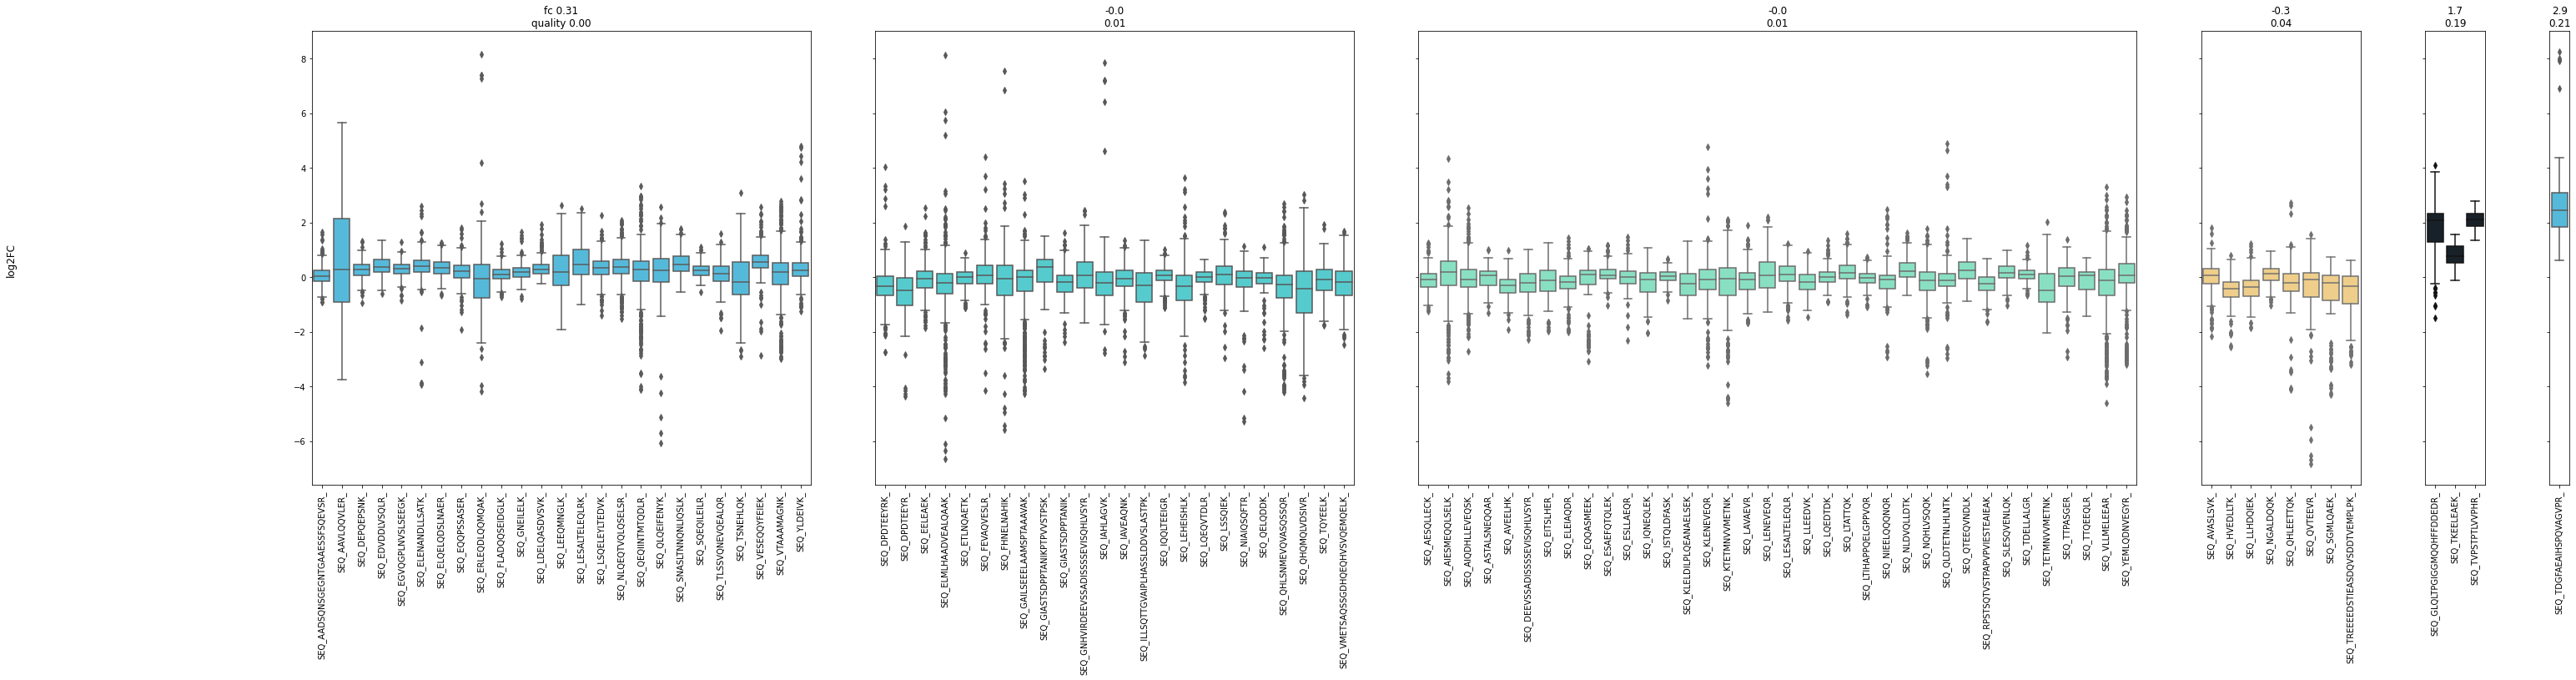

A0A087WZ13


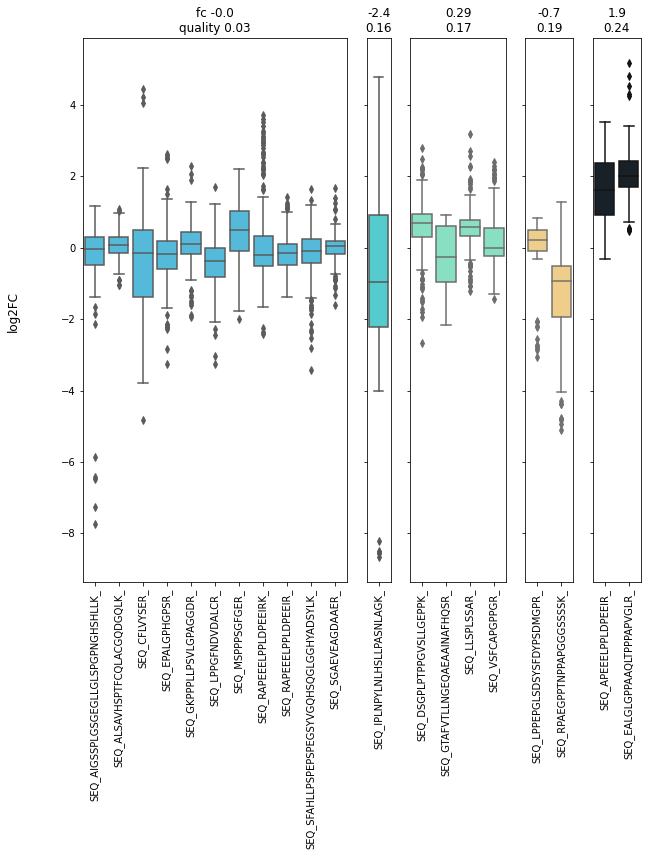

P08574


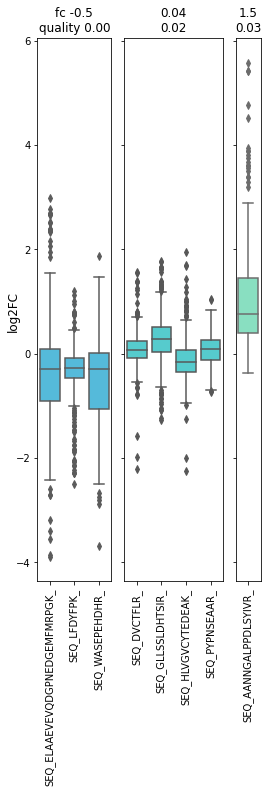

O94901-9


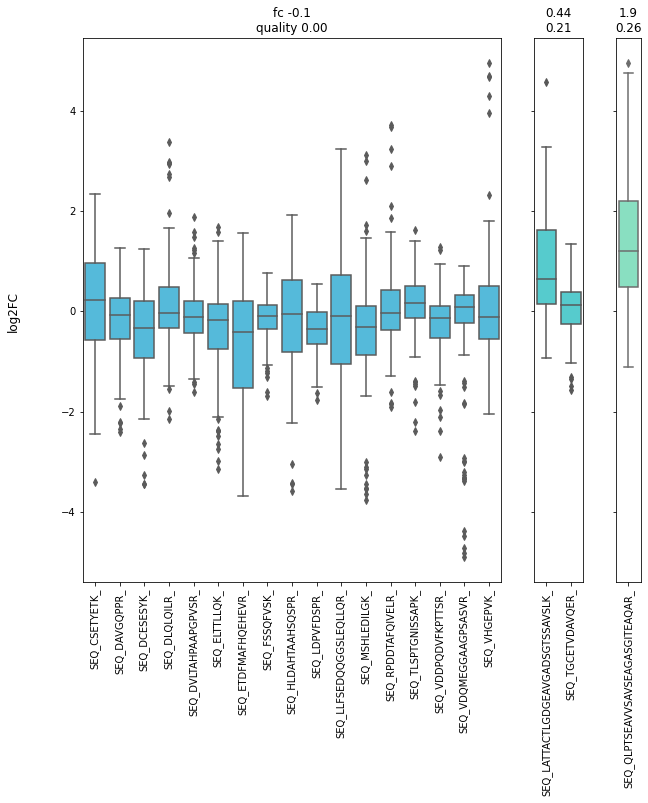

In [ ]:
for protnode in filtered_protnodes[:10]:
    print(protnode.name)
    pcplotter = aqplot.ProteinClusterPlotter(protnode,CONDPAIR, pepdf_getter)
    pcplotter.plot_all_clusters_for_protein()

In [67]:
if True:
    import mygene

    def create_mapping_df(uniprot_ids):
        mg = mygene.MyGeneInfo()
        output = mg.querymany(uniprot_ids, scopes='uniprot', fields=['entrezgene', 'symbol'], species='human')
        
        # create a list of dictionaries to initialize pandas DataFrame
        data = []
        for record in output:
            data.append({
                'uniprot': record['query'], 
                'entrez': record.get('entrezgene', None), 
                'symbol': record.get('symbol', None)
            })
        

            
        return pd.DataFrame(data)

    uniprot_ids = [x.name.split(";")[0] for x in condpairtree_proteome.children]
    mapping_df = create_mapping_df(uniprot_ids)
    mapping_df.to_csv("protein_mapping.tsv", sep="\t", index=None)


INFO:biothings.client:querying 1-1000...
INFO:biothings.client:done.
INFO:biothings.client:querying 1001-2000...
INFO:biothings.client:done.
INFO:biothings.client:querying 2001-3000...
INFO:biothings.client:done.
INFO:biothings.client:querying 3001-4000...
INFO:biothings.client:done.
INFO:biothings.client:querying 4001-5000...
INFO:biothings.client:done.
INFO:biothings.client:querying 5001-6000...
INFO:biothings.client:done.
INFO:biothings.client:querying 6001-6829...
INFO:biothings.client:done.
INFO:biothings.client:Finished.
INFO:biothings.client:Pass "returnall=True" to return complete lists of duplicate or missing query terms.


SEQ_AIGGIILTASHNPGGPNGDFGIK_
outlier fc 0.1680905643618495
modified fc 0.5166003778998194


outlier protnormed 0.25207058896603884
modified protnormed 0.6005804025040087


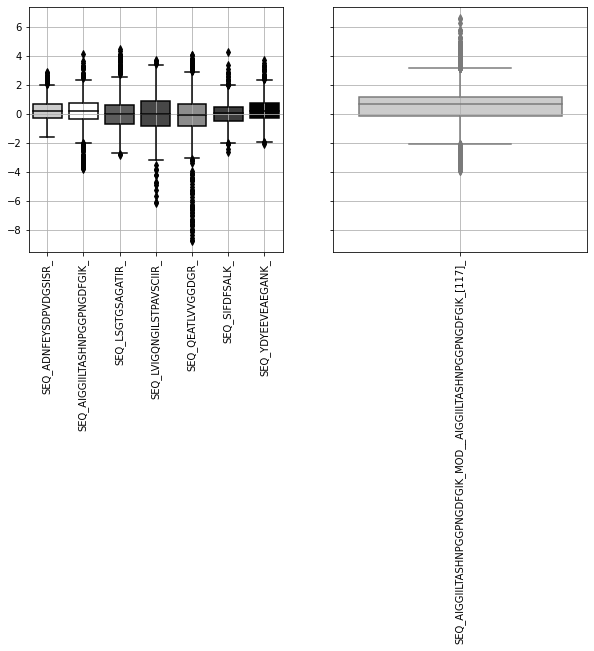

SEQ_PVSSAASVYAGAGGSGSR_
outlier fc 0.27733498718075206
modified fc 1.531487294108624


outlier protnormed -0.6061033233635242
modified protnormed 0.6480489835643476


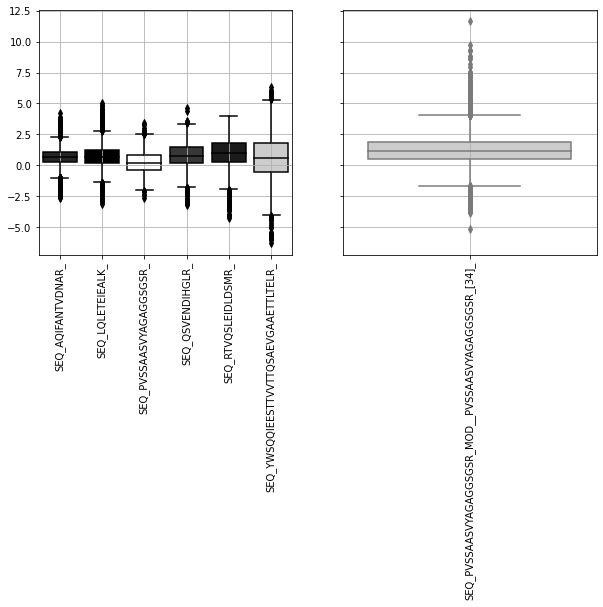

SEQ_EEPSQNDISPK_
outlier fc 0.5920376660145926
modified fc -3.074045533075278


outlier protnormed 1.5996579177232686
modified protnormed -2.066425281366602


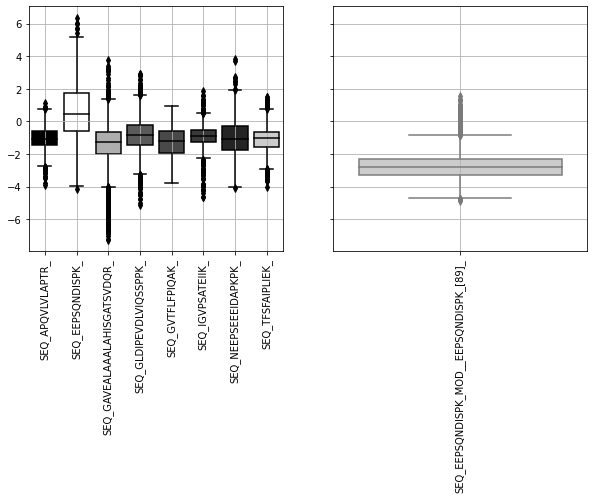

SEQ_MQEAMTQEVSDVFSDTTTPIK_
outlier fc -0.006688072437703335
modified fc -0.5982525101249816


outlier protnormed -0.5556154739894597
modified protnormed -1.147179911676738


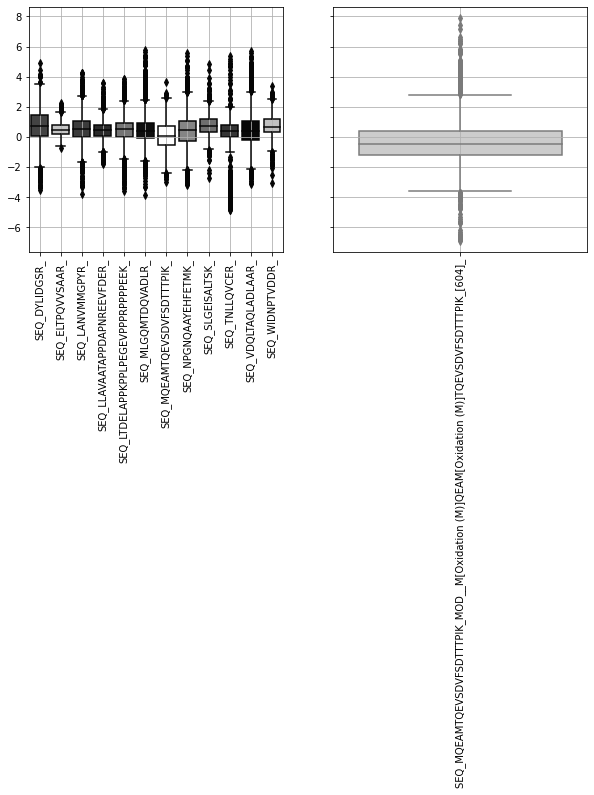

SEQ_SPSDSGYSYETIGK_
outlier fc 1.0690656972028294
modified fc -0.014861272210682286


outlier protnormed -0.027749964548998918
modified protnormed -1.1116769339625105


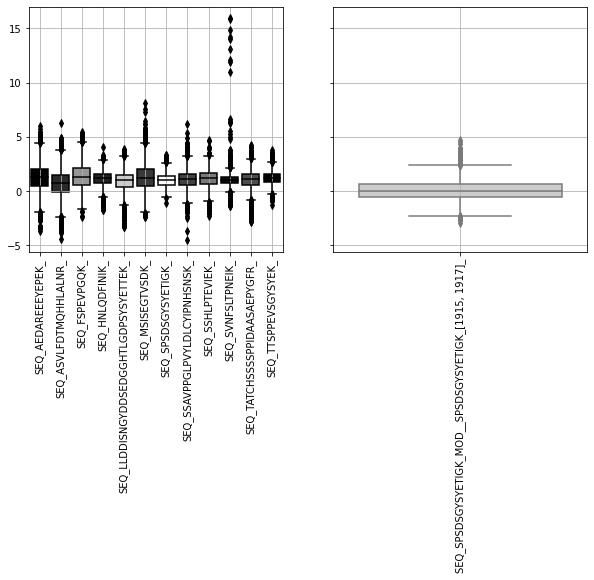

SEQ_ISMSEVDLNVAAPK_
outlier fc 0.49810658873220337
modified fc 1.719596349549095


outlier protnormed -0.4054278764235226
modified protnormed 0.8160618843933689


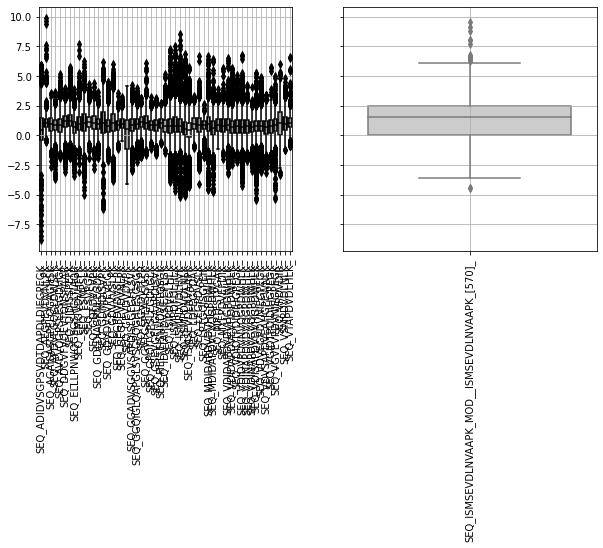

SEQ_SRAEAESMYQIK_
outlier fc 1.1440806076487502
modified fc 0.8923148859573533


outlier protnormed 0.231453925717525
modified protnormed -0.020311795973871893


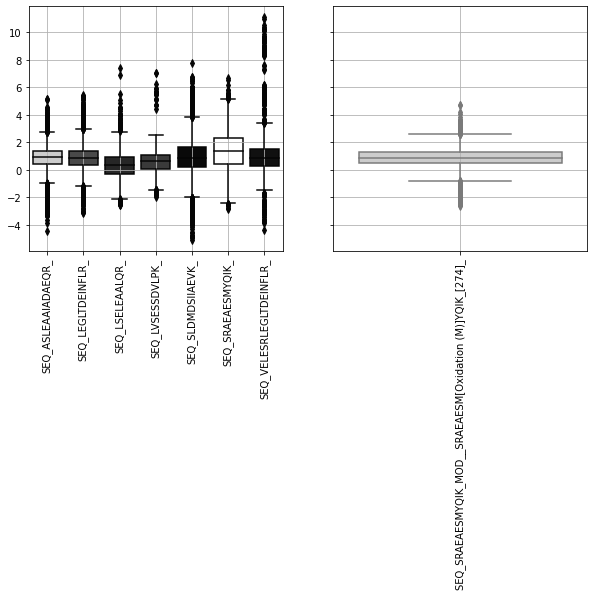

SEQ_TSPSSPAPLPHQEATPR_
outlier fc 0.962065347650278
modified fc 1.246767304211314


outlier protnormed 0.8262294346019254
modified protnormed 1.1109313911629617


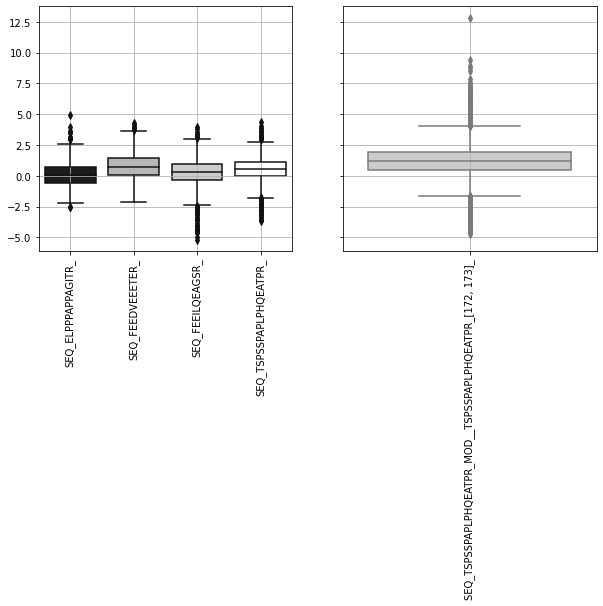

SEQ_HIDCAHVYQNENEVGVAIQEK_
outlier fc 1.5819458037274936
modified fc -0.004639393655431576


outlier protnormed 0.16613771610283345
modified protnormed -1.4204474812800918


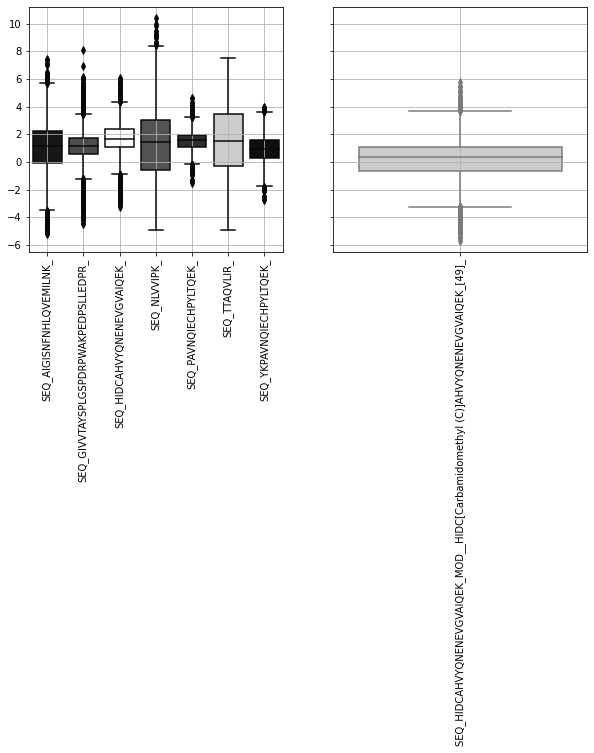

SEQ_ATVVVEATEPEPSGSIANPAASTSPSLSHR_
outlier fc 1.842548586135406
modified fc 0.10152524530296497


outlier protnormed 0.7457329243835777
modified protnormed -0.9952904164488634


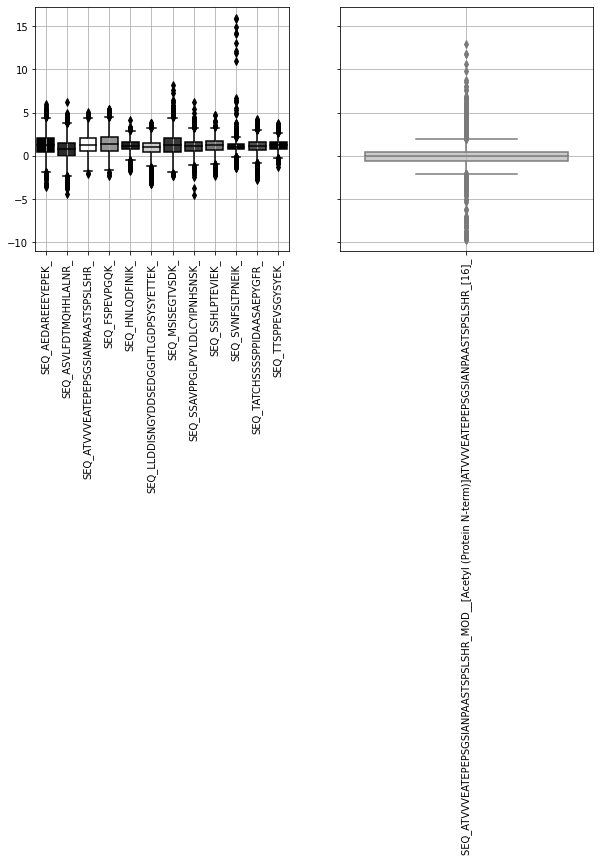

SEQ_SSLGSHQLPR_
outlier fc 0.852189974136957
modified fc 0.2655485281252301


outlier protnormed -0.20638414564152852
modified protnormed -0.7930255916532554


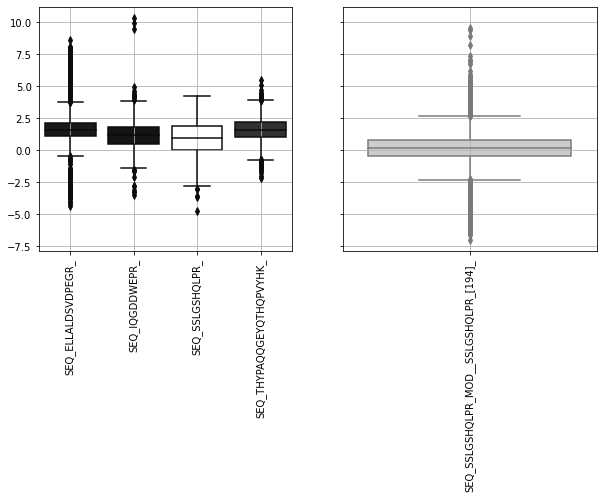

SEQ_GIVVTAYSPLGSPDRPWAK_
outlier fc 0.7370048815131696
modified fc 1.2988801308952076


outlier protnormed -0.6788032061114906
modified protnormed -0.11692795672945255


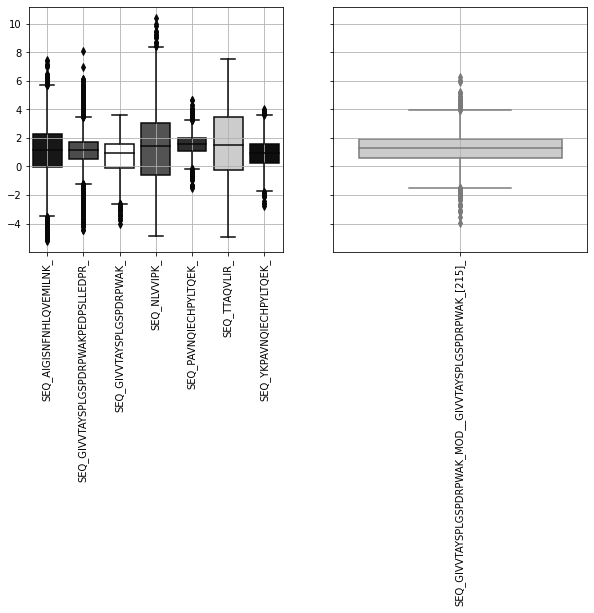

SEQ_VEAPSLDVHMDSPDINIEGPDVK_
outlier fc 0.6083838405428845
modified fc -0.02683226452359698


outlier protnormed -0.2951506246128415
modified protnormed -0.930366729679323


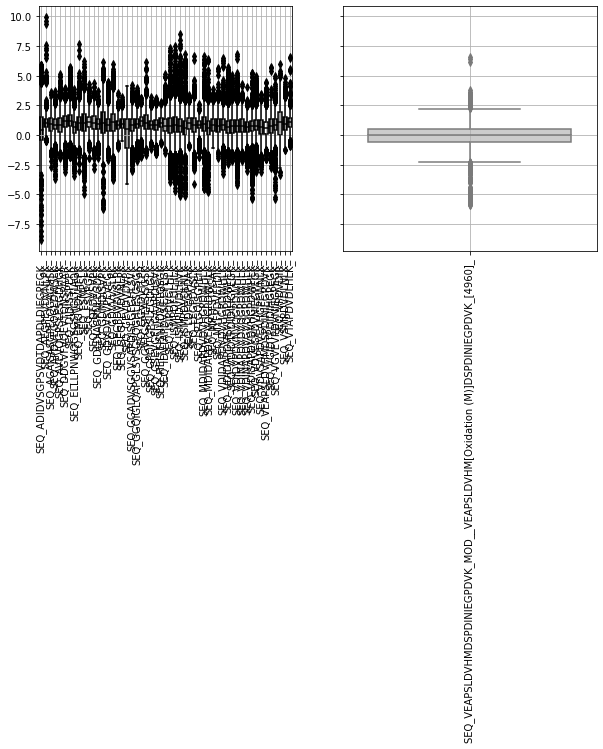

SEQ_SQSPAASDCSSSSSSASLPSSGR_
outlier fc 0.9394104406663301
modified fc 1.139809925543919


outlier protnormed -0.11916367911215542
modified protnormed 0.08123580576543343


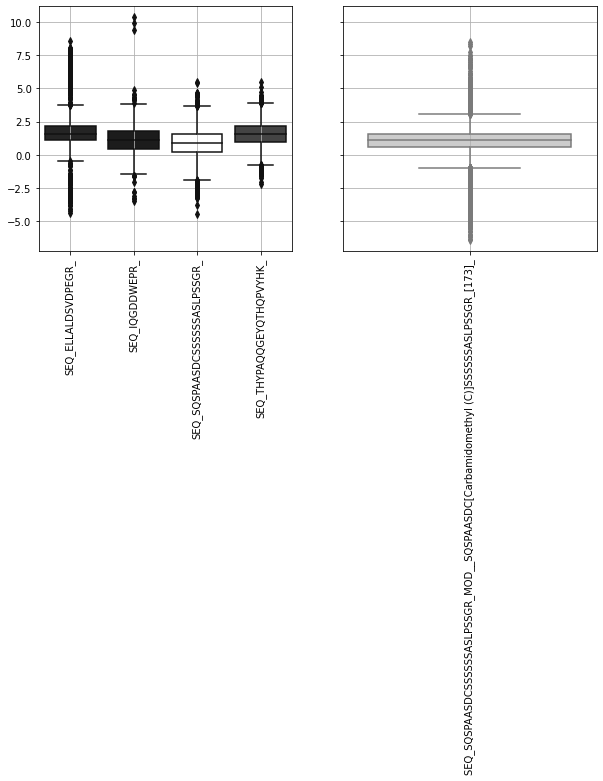

SEQ_LPSEGPRPAHVVVGDVLQAADVDK_
outlier fc 1.0276266151421685
modified fc 1.0443292720818107


outlier protnormed 0.4621738281180763
modified protnormed 0.4788764850577185


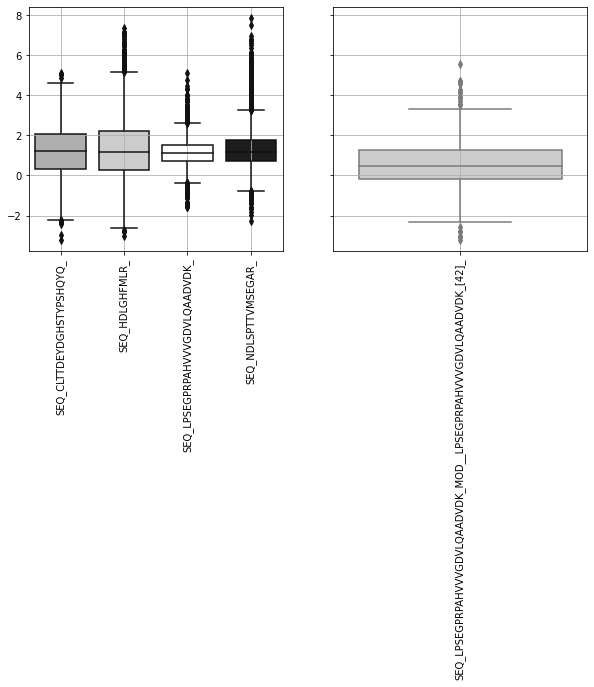

SEQ_GDQPAASGDSDDDEPPPLPR_
outlier fc -0.003863797085631518
modified fc 0.724677740433719


outlier protnormed -0.6106725729858927
modified protnormed 0.11786896453345785


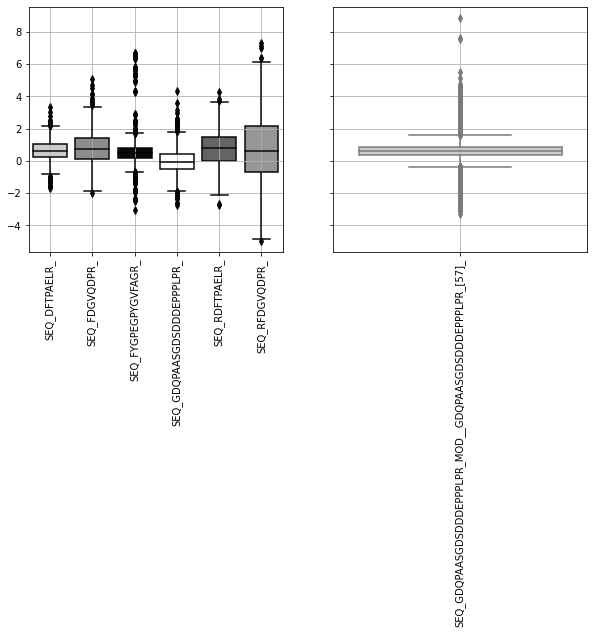

SEQ_ANEPTHFTVDCTEAGEGDVSVGIK_
outlier fc 0.7399321378473644
modified fc 0.19317889622576814


outlier protnormed -0.07745078810769113
modified protnormed -0.6242040297292875


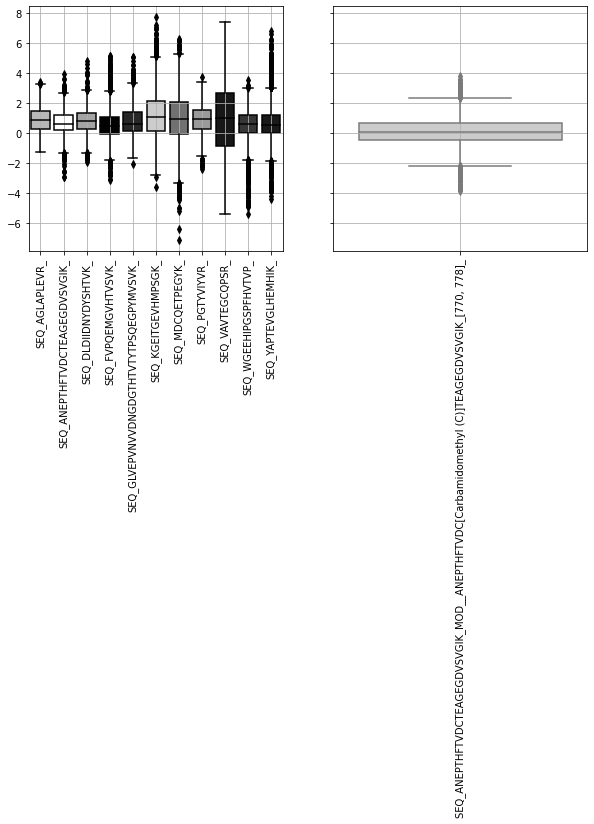

SEQ_TLVSTVGSMVFNEGEAQR_
outlier fc 0.753604299219907
modified fc 1.1194820905697564


outlier protnormed 0.2598379846601401
modified protnormed 0.6257157760099895


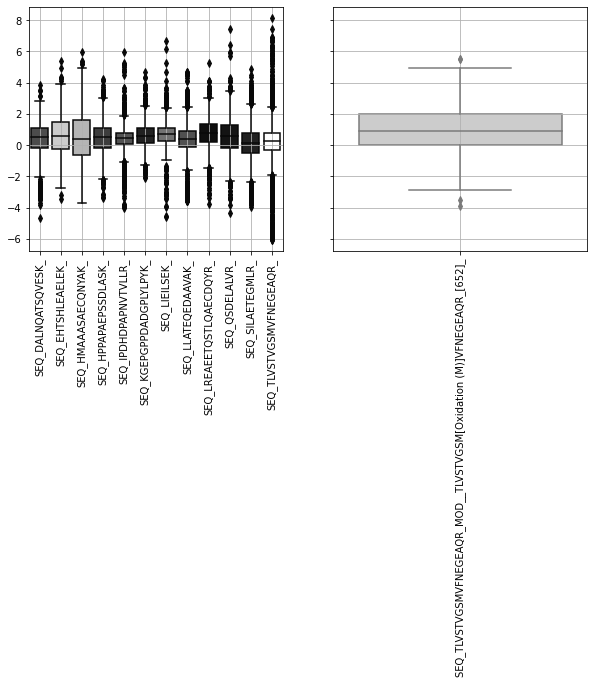

SEQ_EEMQSNVEVVHTYR_
outlier fc 0.35963823393870986
modified fc 0.7370863243594852


outlier protnormed -0.08122875194881846
modified protnormed 0.29621933847195686


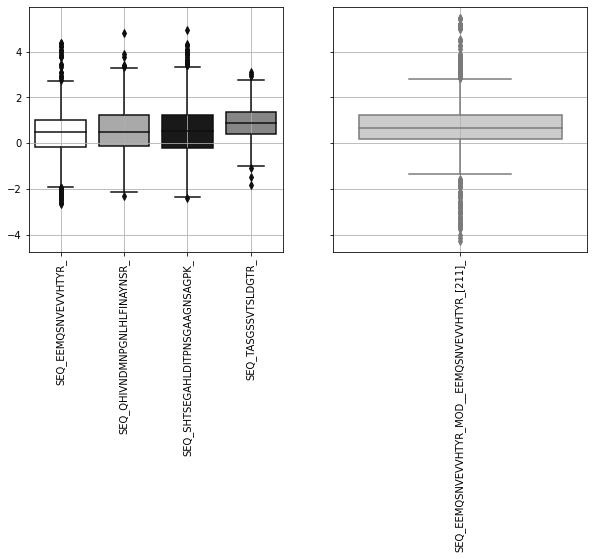

SEQ_SEDGVEGDLGETQSR_
outlier fc 0.2025683995841496
modified fc 1.7384467977926548


outlier protnormed -0.7009660655715764
modified protnormed 0.8349123326369288


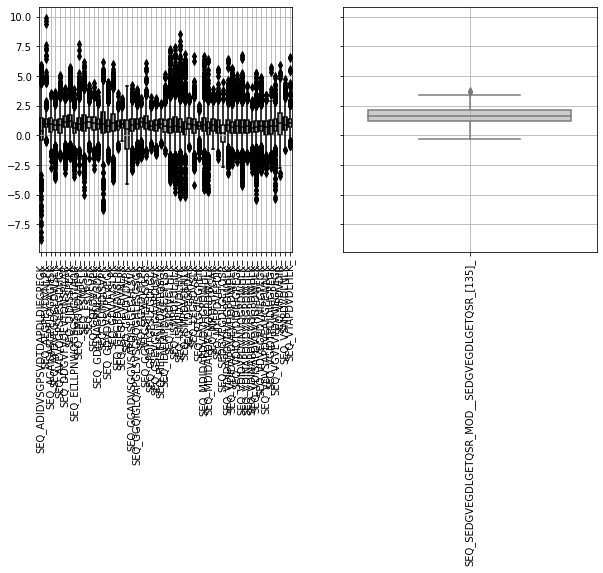

SEQ_QFTPCQLLADHANSPNK_
outlier fc 0.7663975518023085
modified fc -0.5338432664068192


outlier protnormed 0.17134118063011206
modified protnormed -1.1288996375790157


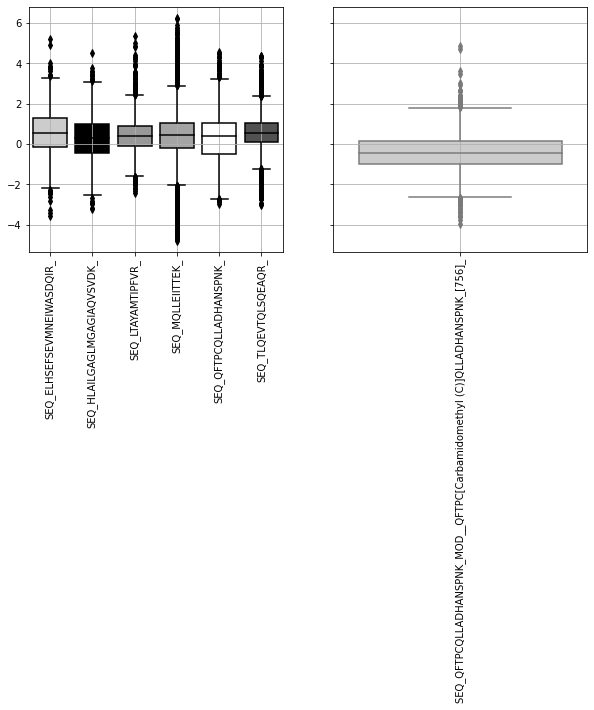

SEQ_AGSNMLLIGVHGPTTPCEEVSMK_
outlier fc 0.8963705416733385
modified fc 1.4355480472613662


outlier protnormed 0.07898761571828294
modified protnormed 0.6181651213063106


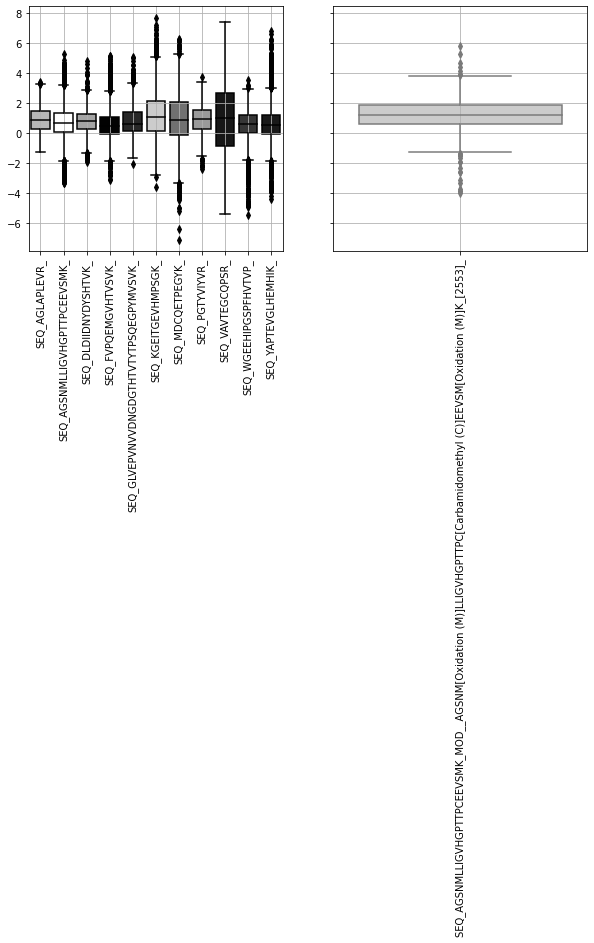

SEQ_TSPADHGGSVGSESGGSAVDSVAGEHSVSGR_
outlier fc 0.04195131688281477
modified fc 0.09137795059198428


outlier protnormed -0.14614281925601763
modified protnormed -0.0967161855468481


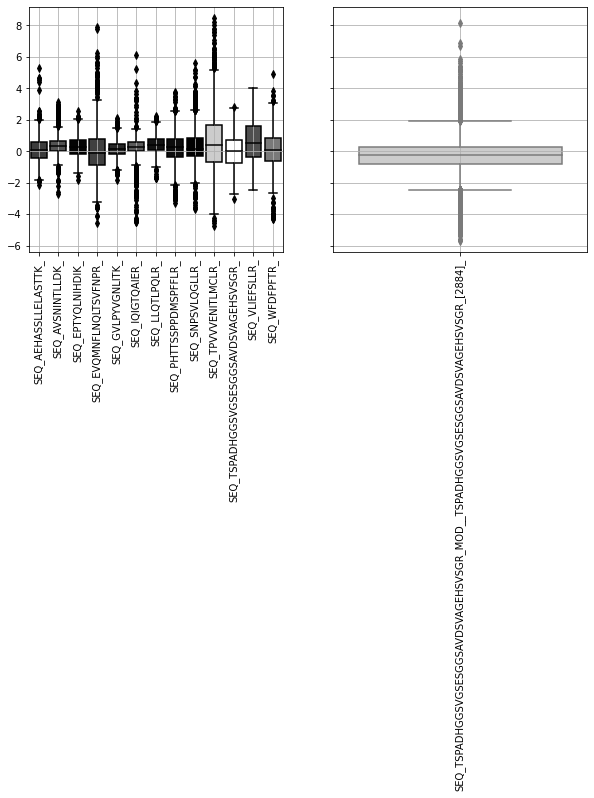

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Some example data to display
x = np.linspace(0, 2 * np.pi, 400)
y = np.sin(x ** 2)

def plot_complemented_cluster_condpairinfo(complemented_cluster,clusterdiffinfos_list):
    fig, (ax1, ax2) = plt.subplots(1,2,sharey=True, sharex=False,figsize=(10,5))

    plot_peptides_of_protein(complemented_cluster,clusterdiffinfos_list, ax1)
    plot_phospho_peptides(complemented_cluster, ax2)
    plt.subplots_adjust(bottom = 0.2)
    ax1.grid(True)
    ax2.grid(True)
    return fig



def plot_peptides_of_protein(complemented_cluster, clusterdiffinfos_list, ax):
    condpairinfo_to_plot  = filter_relevant_condpairinfo_for_complemented_cluster(clusterdiffinfos_list, complemented_cluster)
    peptides_to_plot = condpairinfo_to_plot.mainclust_peptide_names + [complemented_cluster.outlier_peptide.peptide_sequence]
    melted_plot_df = pepdf_getter.get_melted_ion_intensity_table_peptide_subset(protein=condpairinfo_to_plot.protein_name,peptides_to_plot=peptides_to_plot, specified_level="seq")
    fcplotter = aqplot.IonFoldChangePlotter(melted_df=melted_plot_df, condpair = condpair)
    ax_protein = fcplotter.plot_fcs_predscore_relative_strength(ax=ax)
    return ax_protein


def plot_phospho_peptides(complemented_cluster, ax):
    peptides_to_plot =  [complemented_cluster.modified_peptide.modified_sequence]
    melted_plot_df = pepdf_getter_ptm.get_melted_ion_intensity_table_peptide_subset(protein=complemented_cluster.modified_peptide.protein_name,peptides_to_plot=peptides_to_plot, specified_level="mod_seq")
    fcplotter = aqplot.IonFoldChangePlotter(melted_df=melted_plot_df, condpair = condpair)
    ax_ptm = fcplotter.plot_fcs_predscore_relative_strength(ax=ax)
    return ax_ptm


def filter_relevant_condpairinfo_for_complemented_cluster(clusterdiffinfos_list, complemented_cluster):
    return filter(lambda x : complemented_cluster.outlier_peptide.peptide_sequence in x.outlier_peptide_names ,clusterdiffinfos_list).__next__()



compclusts = aqoutlier.ComplementedClusterFilterer(complemented_clusterloader,filterconfigs).get_filtered_complemented_clusters()

count = 0
for clust in compclusts:
    print(clust.outlier_peptide.peptide_sequence)
    print(f"outlier fc {clust.outlier_peptide.fc}")
    print(f"modified fc {clust.modified_peptide.fc}")
    print("\n")
    print(f"outlier protnormed {clust.outlier_peptide.protnormed_fc}")
    print(f"modified protnormed {clust.modified_peptide.protnormed_fc}")
    fig = plot_complemented_cluster_condpairinfo(clust, clusterdiffinfos_list)
    #fig.show()
    plt.show()
    count+=1
    
